# **Pre-ETL**

### **Library Installation**

In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.3 MB 35 kB/s 
     |████████████████████████████████| 198 kB 7.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=a519dc40bef330d6463bdf7b67b0ec40d4de84379030336ac55649ef7a110697
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [ ]:
!pip install deep-translator

     |████████████████████████████████| 97 kB 5.5 MB/s 
     |████████████████████████████████| 97 kB 6.5 MB/s 
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.0.3 which is incompatible.


In [ ]:
!pip install google-play-scraper

     |████████████████████████████████| 52 kB 767 kB/s 
  Created wheel for google-play-scraper: filename=google_play_scraper-1.0.2-py3-none-any.whl size=24393 sha256=32d3b87a5fd0241924b0c6edde9ca57dde8617962c5629c8b7dfd55cb0a64ed4
  Stored in directory: /root/.cache/pip/wheels/98/99/eb/bbb9d24a5c526980647efc10336eaaeffcf07749f581111128
Successfully built google-play-scraper


In [ ]:
!pip install tweet-preprocessor

In [ ]:
!pip install emoji

     |████████████████████████████████| 170 kB 25.8 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=60d9a2e04361a8dd0996054b9ad08a4681897a00cb8a45055acb2ca55a1cdb47
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji


In [ ]:
!pip install boto3

     |████████████████████████████████| 131 kB 24.8 MB/s 
     |████████████████████████████████| 8.2 MB 13.3 MB/s 
     |████████████████████████████████| 79 kB 5.3 MB/s 
     |████████████████████████████████| 138 kB 46.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.7 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
!pip install pymongo pymongo[srv] awscli

     |████████████████████████████████| 3.8 MB 25.9 MB/s 
     |████████████████████████████████| 547 kB 29.2 MB/s 
     |████████████████████████████████| 241 kB 51.8 MB/s 
  Attempting uninstall: docutils
    Found existing installation: docutils 0.17.1
    Uninstalling docutils-0.17.1:
      Successfully uninstalled docutils-0.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


### **API Key**

In [ ]:
# API key, API secret, access token, access token secret
API_KEY = <YOUR_API_KEY>
API_SECRET = <YOUR_API_SECRET>
ACCESS_TOKEN = <YOUR_ACCESS_TOKEN>
ACCESS_TOKEN_SECRET = <YOUR_ACCESS_TOKEN_SECRET>

# Authentification
auth = tw.OAuthHandler(API_KEY, API_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

# API
api = tw.API(auth, wait_on_rate_limit=True)

### **Importing Libraries**

In [ ]:
# PySpark
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, IntegerType, StructType, StructField, TimestampType, FloatType
from pyspark.sql.functions import udf, col

# Scraping Libraries
import tweepy as tw
from google_play_scraper import app, Sort, reviews_all

# Text Processing Libraries
from deep_translator import GoogleTranslator
from textblob import TextBlob
from nltk.corpus import stopwords
import re
import nltk
import preprocessor as p
import emoji

# S3 Load Libraries
import boto3
import io
from io import StringIO

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### **Creating Spark Session**

In [ ]:
spark = SparkSession.builder.appName("AnterajaRevs").getOrCreate()

### **Some Configurations**

In [ ]:
p.set_options(p.OPT.MENTION, p.OPT.EMOJI, p.OPT.HASHTAG, p.OPT.RESERVED, p.OPT.SMILEY, p.OPT.URL)
nltk.download('words')
words = set(nltk.corpus.words.words())

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


# **Extract**

### **A. Scraping Twitter Data**

In [ ]:
# Define the search term and the date_since date as variables
search_words = "anteraja -from:anteraja_id lang:id"
date_year = "2021"
date_month = "10"
date_days = range(10, 18)
date_time = "2315"
screen_name = []
text = []
created_at = []

for date_day in date_days:
  date_since = date_year + date_month + str(date_day) + date_time 
  date_until = date_year + date_month + str(date_day+1) + date_time

  tweets = tw.Cursor(api.search_full_archive,
                    environment_name="TwitterResearch",
                    query=search_words,
                    fromDate=date_since,
                    toDate=date_until).items(100)
  
  for tweet in tweets:
    screen_name.append(tweet.user.screen_name)
    text.append(tweet.text)
    created_at.append(tweet.created_at)

In [ ]:
tweet_data = pd.DataFrame(
    {'username': screen_name,
     'date': created_at,
     'tweet': text
    })

In [ ]:
tweet_data

,username,date,tweet
0,GrabID,2021-10-11 23:09:02,@ezizyaa Kalau itu tergantung kebijakan dari A...
1,GrabID,2021-10-11 22:59:46,@ezizyaa Hai Kak :) buat pengiriman antar kota...
2,marsupilapila,2021-10-11 21:36:13,@anteraja_id mau tanya paket dengan nomor resi...
3,aLpyPutraa,2021-10-11 21:19:56,RT @amiranh_: Halo @anteraja_id saya pesan ops...
4,Naanganang,2021-10-11 21:13:43,@anteraja_id min ini kenapa dari minggu udah a...
...,...,...,...
795,viviankurniawan,2021-10-18 10:46:54,"@anteraja_id oh okay, alasan diretur knp ya ka..."
796,agusminong,2021-10-18 10:45:33,@anteraja_id Pakai pengiriman @anteraja_id bi...
797,vmcinghu,2021-10-18 10:43:18,halo @anteraja_id mohon ingin cepat dikirim ya...
798,Irfan22031,2021-10-18 10:41:31,@anteraja_id Cek dm napa min


In [ ]:
# Defining Spark schema
schema_twt = 'username STRING, date TIMESTAMP, tweet STRING'

In [ ]:
# Converting data type of 'date' column from string to datetime
tweet_data['date'] = pd.to_datetime(tweet_data['date'])

In [ ]:
# Creating Spark dataframe using defined schema
df_Twitter = spark.createDataFrame(tweet_data[['username', 'date', 'tweet']], schema_twt) 

In [ ]:
df_Twitter.printSchema()

root
 |-- username: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- tweet: string (nullable = true)



In [ ]:
df_Twitter.show(n=2)

+--------+-------------------+--------------------+
|username|               date|               tweet|
+--------+-------------------+--------------------+
|  GrabID|2021-10-11 23:09:02|@ezizyaa Kalau it...|
|  GrabID|2021-10-11 22:59:46|@ezizyaa Hai Kak ...|
+--------+-------------------+--------------------+
only showing top 2 rows



### **B. Scraping Google Play Store Review**

In [ ]:
id_reviews = reviews_all(
                        'id.anteraja.aca',
                        sleep_milliseconds=0, # defaults to 0
                        lang='en', # defaults to 'en'
                        country='id', # defaults to 'us'
                        sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
                        )

In [ ]:
# Defining Spark schema
schema_ps = 'userName STRING, at TIMESTAMP, content STRING'

In [ ]:
df_google_play = pd.DataFrame(np.array(id_reviews), columns=['review'])
df_google_play = df_google_play.join(pd.DataFrame(df_google_play.pop('review').tolist()))

# Converting data type of 'at' column from string to datetime
df_google_play['at'] = pd.to_datetime(df_google_play['at'])

In [ ]:
# Creating Spark dataframe using defined schema
df_google_play = spark.createDataFrame(df_google_play[['userName', 'at', 'content']], schema_ps)

In [ ]:
df_google_play.printSchema()

root
 |-- userName: string (nullable = true)
 |-- at: timestamp (nullable = true)
 |-- content: string (nullable = true)



In [ ]:
df_google_play.show(n=2)

+-------------+-------------------+--------------------+
|     userName|                 at|             content|
+-------------+-------------------+--------------------+
| Ahmad Syukri|2021-11-28 12:09:21|Mantabb... Harga ...|
|eliyanto liga|2021-11-28 08:19:34|          👍👍👍👍👍|
+-------------+-------------------+--------------------+
only showing top 2 rows



# **Transform**

### **A. Creating Functions**

#### **1. Defining Translator Function**

In [ ]:
def translator(text):
  text = GoogleTranslator(source='id', target='en').translate(text)
  #text = TextBlob(text).translate(to="en")
  return text
  
#udf_translate = udf(lambda x:translator(x), StringType())

#### **2. Defining Cleansing Function**

In [ ]:
def cleaner(text):
    text = re.sub("@[A-Za-z0-9]+", "", text) #Remove @ sign
    text = ''.join(c for c in text if c not in emoji.UNICODE_EMOJI) #Remove Emojis
    text = text.replace("#", "").replace("_", "") #Remove hashtag sign but keep the text
    text = " ".join(w for w in nltk.wordpunct_tokenize(text) \
         if w.lower() in words or not w.isalpha()) #Remove non-english tweets (not 100% success)
    return text

udf_clean = udf(lambda x:cleaner(x), StringType())

#### **3. Defining Sentiment Score Function**

In [ ]:
def sentiment_score(text):
  blob = TextBlob(str(text))
  score = blob.polarity
  return score

udf_sentiment_score = udf(lambda x:sentiment_score(x), FloatType())

#### **4. Defining Sentiment Analysis Function**

In [ ]:
def sentiment(sentiment_score):
   if sentiment_score > 0:
    return "positive"
   elif sentiment_score < 0:
    return "negative"
   else:
    return "neutral"  

udf_sentiment = udf(lambda x:sentiment(x), StringType())

### **B. Applying Functions to Twitter Data**

In [ ]:
#Create pandas DataFrame, to avoid exceeding rate limit on Google Translator Rate Limit
pd_Twitter = pd.DataFrame(df_Twitter.toPandas()) 
pd_Twitter.head()

,username,date,tweet
0,GrabID,2021-10-11 23:09:02,@ezizyaa Kalau itu tergantung kebijakan dari A...
1,GrabID,2021-10-11 22:59:46,@ezizyaa Hai Kak :) buat pengiriman antar kota...
2,marsupilapila,2021-10-11 21:36:13,@anteraja_id mau tanya paket dengan nomor resi...
3,aLpyPutraa,2021-10-11 21:19:56,RT @amiranh_: Halo @anteraja_id saya pesan ops...
4,Naanganang,2021-10-11 21:13:43,@anteraja_id min ini kenapa dari minggu udah a...


In [ ]:
# Applying Translator Function (Pandas)
pd_Twitter['tweet'] = pd_Twitter['tweet'].map(lambda x: translator(x))

In [ ]:
pd_Twitter.tail()

,username,date,tweet
795,viviankurniawan,2021-10-18 10:46:54,"@anteraja_id oh okay, why did you return it if..."
796,agusminong,2021-10-18 10:45:33,@anteraja_id Using @anteraja_id delivery can b...
797,vmcinghu,2021-10-18 10:43:18,hello @anteraja_id please want to send it quic...
798,Irfan22031,2021-10-18 10:41:31,@anteraja_id Check dm why min
799,blacklist_era,2021-10-18 10:38:48,"@anteraja_id I'm really tired, Ven resentful"


In [ ]:
#Turn Pandas to Spark (For Faster Computation)
df_Twitter=spark.createDataFrame(pd_Twitter)

In [ ]:
# Applying Cleansing Function
df_Twitter = df_Twitter.withColumn("tweet", udf_clean(col("tweet"))).select("username", "date", "tweet")

In [ ]:
df_Twitter.show(n=5)

+-------------+-------------------+--------------------+
|     username|               date|               tweet|
+-------------+-------------------+--------------------+
|       GrabID|2021-10-11 23:09:02|If it on the poli...|
|       GrabID|2021-10-11 22:59:46|Hi Sis :) for int...|
|marsupilapila|2021-10-11 21:36:13|id want to ask fo...|
|   aLpyPutraa|2021-10-11 21:19:56|: Hello id I orde...|
|   Naanganang|2021-10-11 21:13:43|id this min why s...|
+-------------+-------------------+--------------------+
only showing top 5 rows



In [ ]:
# Applying Sentiment Score Function
df_Twitter = df_Twitter.withColumn("sentiment_score", udf_sentiment_score(col("tweet"))).select("username", "date", "tweet", "sentiment_score")

In [ ]:
df_Twitter.show(n=5)

+-------------+-------------------+--------------------+---------------+
|     username|               date|               tweet|sentiment_score|
+-------------+-------------------+--------------------+---------------+
|       GrabID|2021-10-11 23:09:02|If it on the poli...|            0.0|
|       GrabID|2021-10-11 22:59:46|Hi Sis :) for int...|           0.25|
|marsupilapila|2021-10-11 21:36:13|id want to ask fo...|            0.0|
|   aLpyPutraa|2021-10-11 21:19:56|: Hello id I orde...|            0.0|
|   Naanganang|2021-10-11 21:13:43|id this min why s...|            0.0|
+-------------+-------------------+--------------------+---------------+
only showing top 5 rows



In [ ]:
# Applying Sentiment Analysis Function
df_Twitter = df_Twitter.withColumn("sentiment", udf_sentiment(col("sentiment_score"))).select("username", "date", "tweet", "sentiment_score", "sentiment")

In [ ]:
df_Twitter.show(n=7)

+--------------+-------------------+--------------------+---------------+---------+
|      username|               date|               tweet|sentiment_score|sentiment|
+--------------+-------------------+--------------------+---------------+---------+
|        GrabID|2021-10-11 23:09:02|If it on the poli...|            0.0|  neutral|
|        GrabID|2021-10-11 22:59:46|Hi Sis :) for int...|           0.25| positive|
| marsupilapila|2021-10-11 21:36:13|id want to ask fo...|            0.0|  neutral|
|    aLpyPutraa|2021-10-11 21:19:56|: Hello id I orde...|            0.0|  neutral|
|    Naanganang|2021-10-11 21:13:43|id this min why s...|            0.0|  neutral|
|  nanang_indra|2021-10-11 21:09:07|id hello sis rece...|            0.0|  neutral|
|cabangpurnamaa|2021-10-11 19:16:04|, I have to be fu...|            0.0|  neutral|
+--------------+-------------------+--------------------+---------------+---------+
only showing top 7 rows



In [ ]:
export_Twitter = df_Twitter.select("username", "date", "tweet", "sentiment_score", "sentiment")

In [ ]:
#Create pandas DataFrame, to export data
pd_Twitter = pd.DataFrame(export_Twitter.toPandas())

### **C. Applying Functions to Google Play Store Review Data**

In [ ]:
#Create pandas DataFrame, to avoid exceeding rate limit on Google Translator Rate Limit
pd_google_play = pd.DataFrame(df_google_play.toPandas()) 
pd_google_play.head()

,userName,at,content
0,Ahmad Syukri,2021-11-28 12:09:21,Mantabb... Harga bersaing baik di olshop maupu...
1,eliyanto liga,2021-11-28 08:19:34,👍👍👍👍👍
2,sari gatot,2021-11-28 03:13:50,sering kurir anteraja lempar barang2 pesanan s...
3,Vera Puspa Indah,2021-11-28 01:23:53,"Yang disayangkan, sakuajanya tidak bisa di top..."
4,Cimel,2021-11-28 01:06:59,Good


In [ ]:
pd_google_play = pd_google_play[pd_google_play['at'].dt.strftime('%Y-%m-%d') >= "2021-11-11"]
pd_google_play

,userName,at,content
0,Ahmad Syukri,2021-11-28 12:09:21,Mantabb... Harga bersaing baik di olshop maupu...
1,eliyanto liga,2021-11-28 08:19:34,👍👍👍👍👍
2,sari gatot,2021-11-28 03:13:50,sering kurir anteraja lempar barang2 pesanan s...
3,Vera Puspa Indah,2021-11-28 01:23:53,"Yang disayangkan, sakuajanya tidak bisa di top..."
4,Cimel,2021-11-28 01:06:59,Good
...,...,...,...
208,Olivia IPD,2021-11-11 02:34:41,"Pengirimannya cepat, bahkan lebih cepat dari p..."
209,Richard Sebastian,2021-11-11 02:28:34,Pengirimannya cepat dan banyak promonya juga
210,Rifka Fitriana Rahmadani,2021-11-11 02:27:34,works well and really help if you need to send...
211,Devinta Rhista Purnama,2021-11-11 01:57:10,Search history AWB tidak bisa menggunakan nama...


In [ ]:
#Translate from pandas dataframe to GoogleTranslator API
pd_google_play['content'] = pd_google_play['content'].map(lambda x: translator(x))

In [ ]:
pd_google_play.tail()

,userName,at,content
208,Olivia IPD,2021-11-11 02:34:41,"Fast delivery, even faster than expected. Alwa..."
209,Richard Sebastian,2021-11-11 02:28:34,Fast delivery and lots of promotions too
210,Rifka Fitriana Rahmadani,2021-11-11 02:27:34,works well and really help if you need to send...
211,Devinta Rhista Purnama,2021-11-11 01:57:10,Search history AWB can't use the recipient's n...
212,Sitifatimahaz,2021-11-11 01:55:50,The promo wadidaw helps


In [ ]:
pd_google_play = pd_google_play[pd_google_play['content'].notna()]

In [ ]:
pd_google_play.head()

,userName,at,content
0,Ahmad Syukri,2021-11-28 12:09:21,Great... Competitive prices both in olshops an...
2,sari gatot,2021-11-28 03:13:50,Anteraja couriers often throw the things I ord...
3,Vera Puspa Indah,2021-11-28 01:23:53,"Unfortunately, the pocket can't be topped up."
4,Cimel,2021-11-28 01:06:59,good
5,soetardjo shari,2021-11-28 01:06:23,Best application and your employee is really p...


In [ ]:
#Turn Pandas to Spark (For Faster Computation)
df_google_play=spark.createDataFrame(pd_google_play)

In [ ]:
df_google_play.show(2)

+------------+-------------------+--------------------+
|    userName|                 at|             content|
+------------+-------------------+--------------------+
|Ahmad Syukri|2021-11-28 12:09:21|Great... Competit...|
|  sari gatot|2021-11-28 03:13:50|Anteraja couriers...|
+------------+-------------------+--------------------+
only showing top 2 rows



In [ ]:
# Applying Cleansing Function
df_google_play = df_google_play.withColumn("content", udf_clean(col("content"))).select("userName", "at", "content")

In [ ]:
df_google_play.show(5)

+----------------+-------------------+--------------------+
|        userName|                 at|             content|
+----------------+-------------------+--------------------+
|    Ahmad Syukri|2021-11-28 12:09:21|Great ... Competi...|
|      sari gatot|2021-11-28 03:13:50|often throw the I...|
|Vera Puspa Indah|2021-11-28 01:23:53|Unfortunately , t...|
|           Cimel|2021-11-28 01:06:59|                good|
| soetardjo shari|2021-11-28 01:06:23|Best application ...|
+----------------+-------------------+--------------------+
only showing top 5 rows



In [ ]:
# Applying Sentiment Score Function
df_google_play = df_google_play.withColumn("sentiment_score", udf_sentiment_score(col("content"))).select("userName", "at", "content", "sentiment_score")

In [ ]:
df_google_play.show(n=5)

+----------------+-------------------+--------------------+---------------+
|        userName|                 at|             content|sentiment_score|
+----------------+-------------------+--------------------+---------------+
|    Ahmad Syukri|2021-11-28 12:09:21|Great ... Competi...|     0.53333336|
|      sari gatot|2021-11-28 03:13:50|often throw the I...|            0.0|
|Vera Puspa Indah|2021-11-28 01:23:53|Unfortunately , t...|           -0.5|
|           Cimel|2021-11-28 01:06:59|                good|            0.7|
| soetardjo shari|2021-11-28 01:06:23|Best application ...|        0.65625|
+----------------+-------------------+--------------------+---------------+
only showing top 5 rows



In [ ]:
# Applying Sentiment Category Function
df_google_play = df_google_play.withColumn("sentiment", udf_sentiment(col("sentiment_score"))).select("userName", "at", "content", "sentiment_score", "sentiment")

In [ ]:
df_google_play.show(n=5)

+----------------+-------------------+--------------------+---------------+---------+
|        userName|                 at|             content|sentiment_score|sentiment|
+----------------+-------------------+--------------------+---------------+---------+
|    Ahmad Syukri|2021-11-28 12:09:21|Great ... Competi...|     0.53333336| positive|
|      sari gatot|2021-11-28 03:13:50|often throw the I...|            0.0|  neutral|
|Vera Puspa Indah|2021-11-28 01:23:53|Unfortunately , t...|           -0.5| negative|
|           Cimel|2021-11-28 01:06:59|                good|            0.7| positive|
| soetardjo shari|2021-11-28 01:06:23|Best application ...|        0.65625| positive|
+----------------+-------------------+--------------------+---------------+---------+
only showing top 5 rows



In [ ]:
export_google_play = df_google_play.select("userName", "at", "content", "sentiment_score", "sentiment")

In [ ]:
#Create pandas DataFrame, to export data
pd_google_play = pd.DataFrame(export_google_play.toPandas()) 

# **Load**

In [ ]:
!aws configure

In [ ]:
# Load df_Twitter to S3
filename= "twitter_sentiment.csv"
bucketName = 'sentiment-data-anteraja'
folder_name = "twitter_sentiment/"

csv_buffer = StringIO()
pd_Twitter.to_csv(csv_buffer, index=False)

client = boto3.client("s3")

response = client.put_object(
    Body = csv_buffer.getvalue(),
    Bucket = bucketName,
    Key = folder_name+filename
)

In [ ]:
# Load df_google_play to S3
filename= "google_play_sentiment.csv"
bucketName = 'sentiment-data-anteraja'
folder_name = "google_play_sentiment/"

csv_buffer = StringIO()
pd_google_play.to_csv(csv_buffer, index=False)

client = boto3.client("s3")

response = client.put_object(
    Body = csv_buffer.getvalue(),
    Bucket = bucketName,
    Key = folder_name+filename
)

# **Basic Viz**

### **A. Twitter Sentiment Analysis**

In [ ]:
tmp_Twitter = pd_Twitter.groupby(pd_Twitter.date.dt.day).agg('mean')

In [ ]:
tmp_Twitter = tmp_Twitter.reset_index()

In [ ]:
tmp_Twitter

,date,sentiment_score
0,11,0.096015
1,12,0.061876
2,13,0.032035
3,14,0.039441
4,15,-0.001666
5,16,0.044647
6,17,0.070348
7,18,0.114168


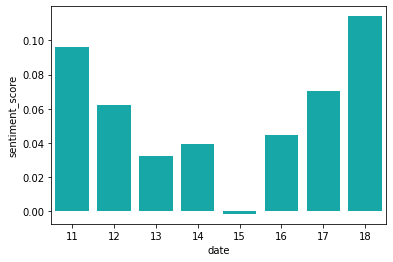

In [ ]:
sns.barplot(x="date", y="sentiment_score", color="c", data=tmp_Twitter)

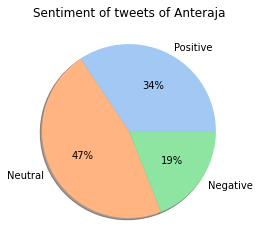

In [ ]:
sentiment_Twitter_dict = {'positive': 0, 'negative': 0, 'neutral': 0}
for sentiment in pd_Twitter["sentiment"]:
  if sentiment == "positive":
      sentiment_Twitter_dict['positive'] += 1
  elif sentiment == "neutral":
      sentiment_Twitter_dict['neutral'] += 1
  elif sentiment == "negative":
      sentiment_Twitter_dict['negative'] += 1

sentiment_Twitter = np.array([sentiment_Twitter_dict["positive"], sentiment_Twitter_dict["neutral"], sentiment_Twitter_dict["negative"]])
labels = ["Positive", "Neutral", "Negative"]
colors = sns.color_palette('pastel')[0:5]

plt.pie(sentiment_Twitter, labels=labels, colors=colors, shadow=True, autopct='%.0f%%')
plt.title("Sentiment of tweets of Anteraja")
plt.show()

### **B. Google Play Sentiment Analysis**

In [ ]:
tmp_google_play = pd_google_play.groupby(pd_google_play['at'].dt.day).agg('mean')

In [ ]:
tmp_google_play = tmp_google_play.reset_index()

In [ ]:
tmp_google_play

,at,sentiment_score
0,11,0.073112
1,12,0.208028
2,13,0.084333
3,14,0.040044
4,15,0.010236
5,16,-0.045547
6,17,-0.060102
7,18,0.274267
8,19,0.006458
9,20,0.178095


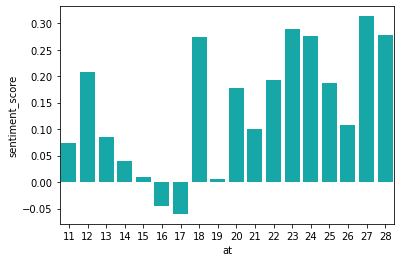

In [ ]:
sns.barplot(x="at", y="sentiment_score", color="c", data=tmp_google_play)

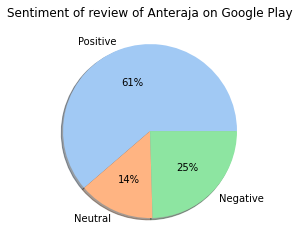

In [ ]:
sentiment_google_play_dict = {'positive' : 0, 'negative' : 0, 'neutral': 0}
for sentiment in pd_google_play["sentiment"]:
  if sentiment == "positive":
      sentiment_google_play_dict['positive'] += 1
  elif sentiment == "neutral":
      sentiment_google_play_dict['neutral'] += 1
  elif sentiment == "negative":
      sentiment_google_play_dict['negative'] += 1

sentiment_google_play = np.array([sentiment_google_play_dict["positive"], sentiment_google_play_dict["neutral"], sentiment_google_play_dict["negative"]])
labels = ["Positive", "Neutral", "Negative"]
colors = sns.color_palette('pastel')[0:5]

plt.pie(sentiment_google_play, labels=labels, colors=colors, shadow=True, autopct='%.0f%%')
plt.title("Sentiment of review of Anteraja on Google Play")
plt.show() 